Motorcycle Night Ride (Semantic Segmentation)

- 실제 사진 200장
- 라벨 사진 200장
- 변환용 사진 200장

In [ ]:
# $ mkdir ~/work/motorcycle
# $ pip install kaggle

In [ ]:
# $ mkdir ~/.kaggle
# $ mv kaggle.json ~/.kaggle/kaggle.json
# $ cd ~/work/motorcycle
# $ kaggle datasets download -d sadhliroomyprime/motorcycle-night-ride-semantic-segmentation
# $ unzip motorcycle-night-ride-semantic-segmentation.zip

## 과업

1. 상대적으로 적은 양의 도로주행 이미지 데이터를 활용하여 multiclass semantic segmentation을 수행합니다. 충돌 시 큰 위험을 맞이하는 도로 주행 환경에 맞춰, 모델의 성능 지표를 상세하게 설정해야 합니다
2. CAM을 통해 오브젝트의 어느 부분이 class를 결정하는데 영향을 미쳤는지 시각화하여 확인해봅니다.
3. W&B를 통해 모델 학습 및 파라미터를 관리합니다.

## 규칙

1. 프로젝트 제출 기한내 LMS의 프로젝트 제출 스텝에서 결과 노트북의 링크를 제출해주세요.
2. 프로젝트 제출 스텝의 루브릭을 따라 노트북의 내용을 채워주세요.
3. 외부 데이터 활용은 허용하되, 제공된 데이터를 활용한 기록이 필수적으로 포함되어야 합니다.
4. 부정 제출 행위를 금지하고 있으며, 부정 제출 이력이 있는 경우 평가가 제한됩니다.

## 평가항목

- 데이터 EDA와 데이터 전처리가 적절하게 이뤄졌는가?
- Task에 알맞게 적절한 모델을 찾아보고 선정했는가?
- 성능향상을 위해 논리적으로 접근했는가?
- 결과 도출을 위해 여러가지 시도를 진행했는가?
- 도출된 결론에 충분한 설득력이 있는가?
- 적절한 metric을 설정하고 그 사용 근거 및 결과를 분석하였는가?
- 발표가 매끄럽게 진행되었고 발표시간을 준수하였는지?

# Motorcycle Night Ride

## 프로젝트 개요
- **데이터셋**: Acme AI Open Dataset - Motorcycle Night Ride (야간 오토바이 주행, 200프레임)
- **목표**: 시멘틱 세그멘테이션 모델로 도로 장면을 분석하여 **프레임별 안전 점수** 산출

### 데이터 전처리 및 검증
- 클래스 ID 재매핑 : COCO → 연속 정수 인덱스
- 품질 체크 및 불균형 확인
- 리사이징 : 512×512
- ImageNet 정규화
- 증강 4가지 사용

### 사용 모델
- **DeepLabV3+** : Atrous convolution + Encoder-Decoder, torchvision 제공
- **SegFormer** : Transformer 기반, HuggingFace pretrained
- **BiSeNetV2** : 경량 실시간 모델, Detail + Semantic 이중 경로

### 추가 분석
- **GradCAM**: 각 클래스 예측에 영향을 미친 이미지 영역 시각화

---
### 0. 환경 구성
---

In [1]:
# 🏷️🏷️🏷️ 필요한 도구 가져오기 및 환경 설정 🏷️🏷️🏷️
import os, json, warnings, gc
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
import torchvision.models as models
from torchvision.models.segmentation import deeplabv3_resnet50

from transformers import SegformerForSemanticSegmentation

from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO

import albumentations as A    # 데이터 증강용
from albumentations.pytorch import ToTensorV2

# 그래프에서 한글이 깨지지 않게 설정 
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# GPU/CPU 선택
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f'Device: {device}')
print(f'PyTorch: {torch.__version__}')

Device: cuda
PyTorch: 2.7.1+cu118


---
### 1. 데이터 EDA
---

In [2]:
# 🏷️🏷️🏷️ 데이터 찾아오기: 사진 파일 분류 🏷️🏷️🏷️
# 사진이 들어있는 폴더 경로를 설정하고 파일을 종류별로 분류한다.
DATA_DIR = "/home/jovyan/work/motorcycle/www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
DATA_DIR = Path(DATA_DIR)
IMAGE_DIR = DATA_DIR / "images"
JSON_PATH = DATA_DIR / "COCO_motorcycle (pixel).json"

# 파일 분류
all_files = sorted(os.listdir(IMAGE_DIR))
original_files = [f for f in all_files if not f.endswith('___fuse.png') and not f.endswith('___save.png')]
mask_files_png = [f for f in all_files if f.endswith('___save.png')]
fuse_files = [f for f in all_files if f.endswith('___fuse.png')]



# 🏷️🏷️🏷️ 품질 검사: 불량 데이터 골라내기 🏷️🏷️🏷️
broken_images = []
missing_masks = []

# 깨진 이미지 있는지 체크
for f in original_files:
    img_path = IMAGE_DIR / f
    try:
        with Image.open(img_path) as im:
            im.verify()  # 사진이 안 깨졌는지 확인!
    except Exception:
        broken_images.append(f)

# 마스크 이미지 누락됐는지 체크 (원본마다 ___save.png 있는지)
mask_set = set(mask_files_png)
for f in original_files:
    expected_mask = f + "___save.png"
    if expected_mask not in mask_set:
        missing_masks.append(f)    # 정답지가 없는 사진 체크!

bad_files = set(broken_images) | set(missing_masks)

print(f"\n깨진 원본 이미지: {len(broken_images)}개")
if broken_images[:5]:
    print("   예시:", broken_images[:5])

print(f"마스크 누락 원본: {len(missing_masks)}개")
if missing_masks[:5]:
    print("   예시:", missing_masks[:5])



# 🏷️🏷️🏷️ COCO 파일 로딩 및 정리 🏷️🏷️🏷️
# JSON 파일을 읽고, 불량 데이터를 제외한 진짜 리스트를 만든다.
coco = COCO(str(JSON_PATH))

# 카테고리 정보
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
cat_id_to_name = {c['id']: c['name'] for c in cats}
img_ids = coco.getImgIds()

print(f'\n이미지 수: {len(img_ids)}')
print(f'어노테이션 수: {len(coco.getAnnIds())}')



# 🏷️🏷️🏷️ "품질 검사 통과한 파일"만 담기 🏷️🏷️🏷️
valid_img_ids = []
skipped = 0
for img_id in img_ids:
    info = coco.loadImgs(img_id)[0]
    fname = info["file_name"]

    # 파일이 실제로 존재하는지
    if not (IMAGE_DIR / fname).exists():
        skipped += 1
        continue

    # 깨진 파일 or 마스크 누락 파일 제외
    if fname in bad_files:
        skipped += 1
        continue

    valid_img_ids.append(img_id)

img_ids = valid_img_ids  # ★ 변수명 유지(이후 흐름 그대로)

print(f"사용되는 이미지 img_ids={len(img_ids)}개, 제외={skipped}개")

# 인덱스 0,1,2... 순으로 순서대로 정리
sorted_cat_ids = sorted(cat_id_to_name.keys())
cat_remap = {0: 0}
for new_id, orig_id in enumerate(sorted_cat_ids, start=1):
    cat_remap[orig_id] = new_id

num_classes = len(cat_remap)
id_to_name = {0: 'Background'}
for orig_id, new_id in cat_remap.items():
    if orig_id != 0:
        id_to_name[new_id] = cat_id_to_name[orig_id]
class_names = [id_to_name[i] for i in range(num_classes)]

print(f'\n클래스 매핑 (총 {num_classes}개):')
for i, name in enumerate(class_names):
    print(f'   {i}: {name}')


깨진 원본 이미지: 0개
마스크 누락 원본: 0개
loading annotations into memory...
Done (t=2.09s)
creating index...
index created!

이미지 수: 200
어노테이션 수: 2305
사용되는 이미지 img_ids=200개, 제외=0개

클래스 매핑 (총 7개):
   0: Background
   1: Undrivable
   2: Road
   3: Lane Mark
   4: Moveable
   5: My bike
   6: Rider


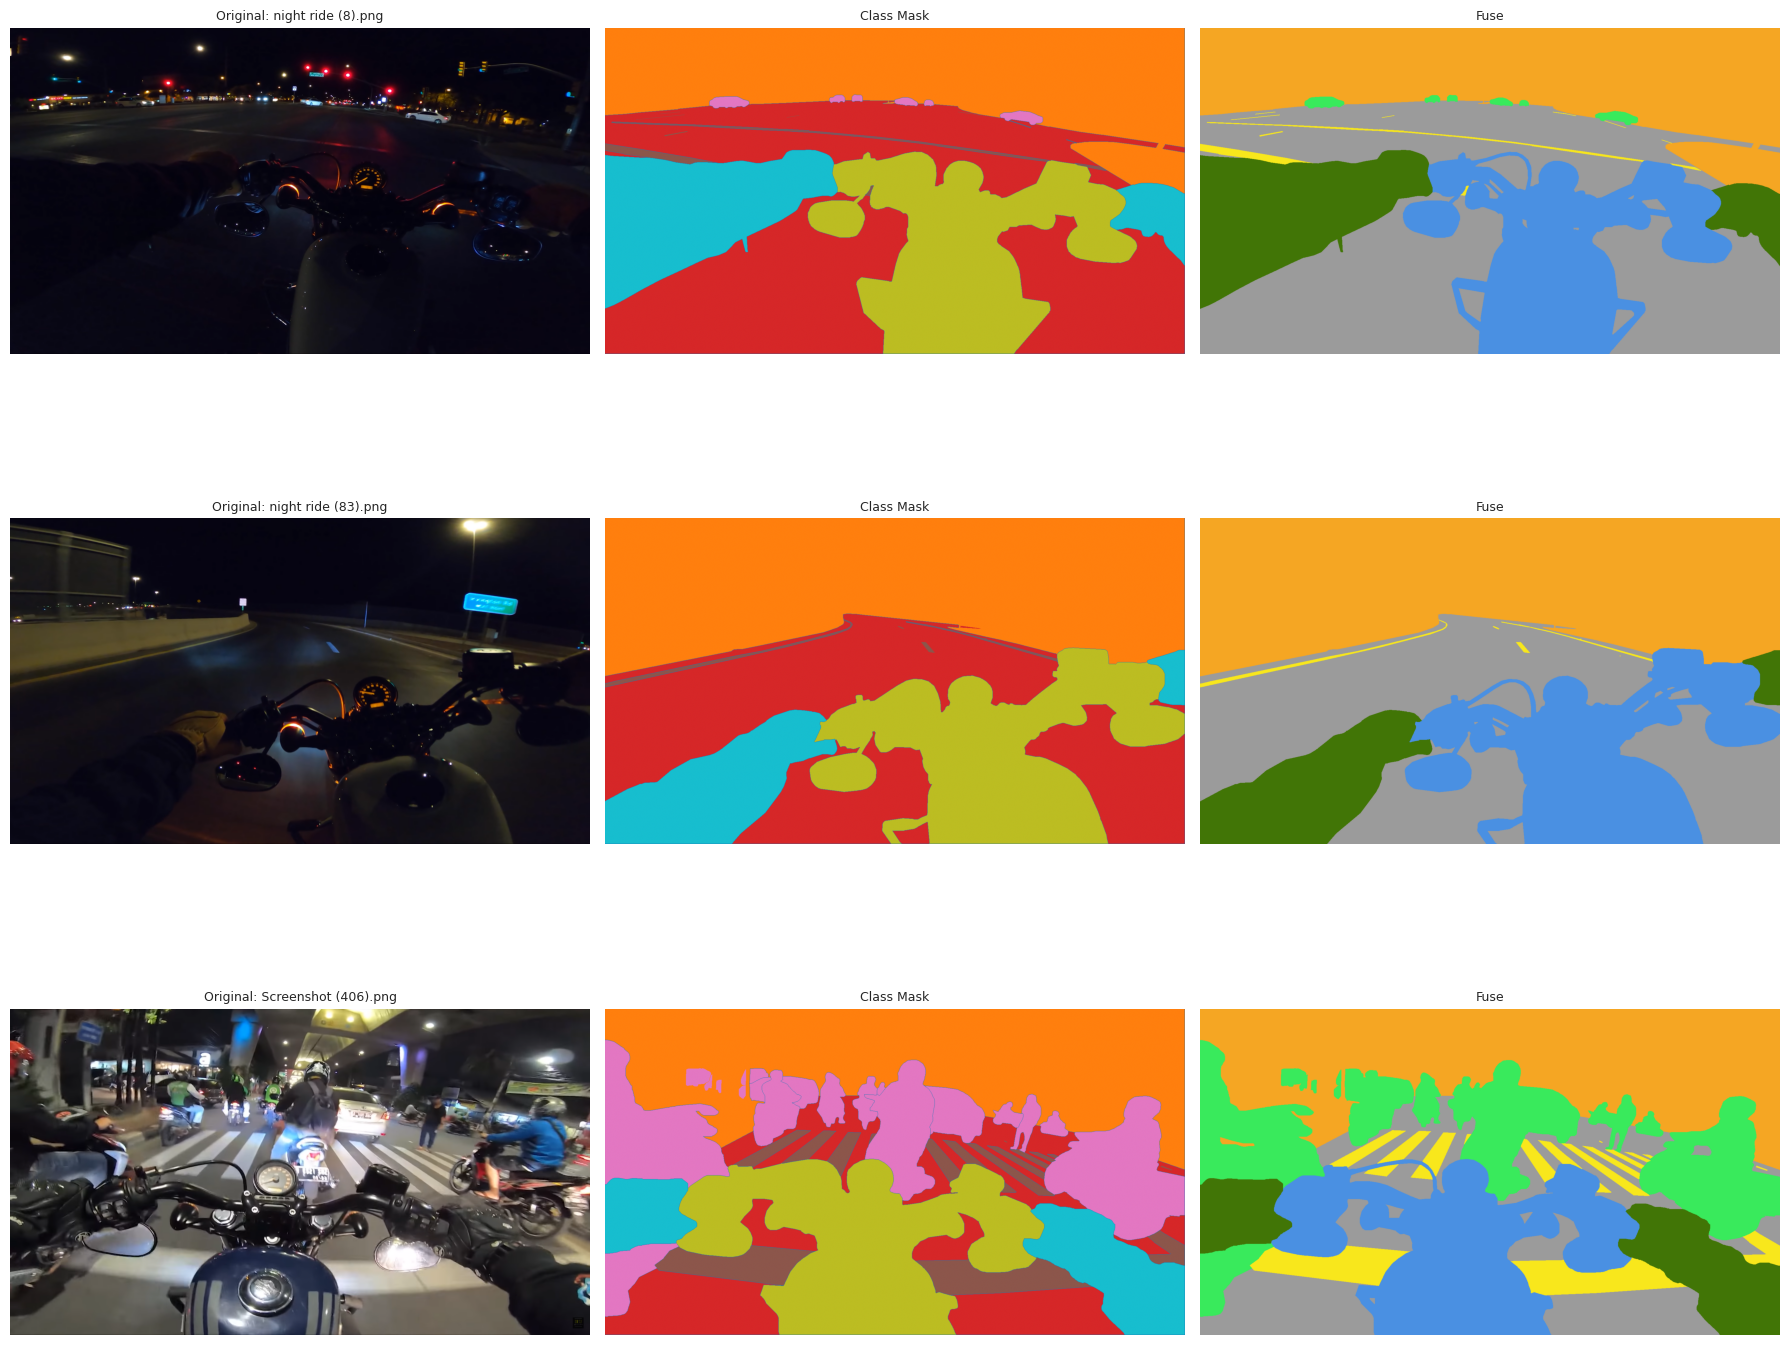

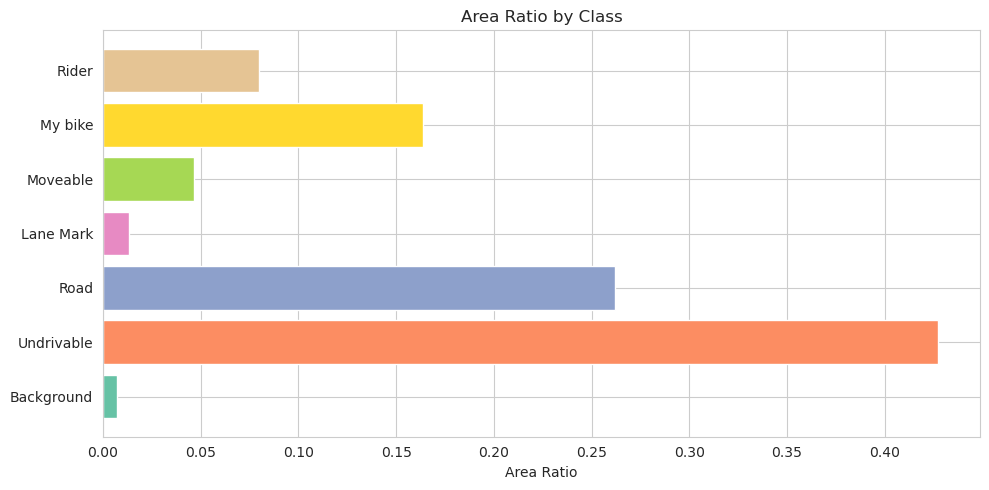

In [3]:
# 🏷️🏷️🏷️ 데이터 시각화 및 분석: 눈으로 확인하기 🏷️🏷️🏷️
# JSON 파일 안에 흩어져 있는 "좌표 정보(Annotation)"들을 모아 하나의 Segmentation Mask으로 만들어주는 함수 
def create_class_mask(coco_api, img_id, remap):
    img_info = coco_api.loadImgs(img_id)[0]
    h, w = img_info['height'], img_info['width']
    mask = np.zeros((h, w), dtype=np.uint8)
    ann_ids = coco_api.getAnnIds(imgIds=img_id)
    anns = coco_api.loadAnns(ann_ids)
    for ann in anns:
        try:
            binary_mask = coco_api.annToMask(ann)
            new_id = remap.get(ann['category_id'], 0)
            mask[binary_mask > 0] = new_id
        except:
            pass
    return mask

# 샘플 시각화 (3장)
sample_ids = [img_ids[0], img_ids[len(img_ids)//3], img_ids[2*len(img_ids)//3]]
fig, axes = plt.subplots(3, 3, figsize=(18, 16))

for i, img_id in enumerate(sample_ids):
    info = coco.loadImgs(img_id)[0]
    fname = info['file_name']
    img = Image.open(IMAGE_DIR / fname)
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original: {fname}', fontsize=9)
    axes[i, 0].axis('off')

    mask = create_class_mask(coco, img_id, cat_remap)
    axes[i, 1].imshow(mask, cmap='tab10', vmin=0, vmax=num_classes-1)
    axes[i, 1].set_title('Class Mask', fontsize=9)
    axes[i, 1].axis('off')

    fuse_path = IMAGE_DIR / (fname + '___fuse.png')
    if fuse_path.exists():
        axes[i, 2].imshow(Image.open(fuse_path))
    axes[i, 2].set_title('Fuse', fontsize=9)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# 데이터 불균형 문제 확인 위해 각 클래스가 차지하는 픽셀 수를 센다.
class_pixel_counts = Counter()   # 각 클래스(0, 1, 2...)별 픽셀 개수를 저장할 카운터를 초기화
total_pixels = 0   # 전체 픽셀 수를 저장할 변수
for img_id in img_ids:   # 모든 이미지에 대해 다음을 반복
    mask = create_class_mask(coco, img_id, cat_remap)   # 마스크 만들기
    unique, counts = np.unique(mask, return_counts=True)   # 각 클래스 개수 세기
    for u, c in zip(unique, counts):
        class_pixel_counts[u] += c 
    total_pixels += mask.size

class_ratios = {class_names[k]: v / total_pixels for k, v in class_pixel_counts.items() if k < num_classes}
fig, ax = plt.subplots(figsize=(10, 5))
names = list(class_ratios.keys())
ratios = [class_ratios[n] for n in names]
ax.barh(names, ratios, color=sns.color_palette('Set2', len(names)))
ax.set_xlabel('Area Ratio')
ax.set_title('Area Ratio by Class')
plt.tight_layout()
plt.show()

---
### 2. 데이터 전처리
---

In [4]:
for n, r in sorted(class_ratios.items(), key=lambda x: -x[1]):
    print(f'  {n:>15s}: {r*100:.2f}%')
print(f'\n이미지 해상도: {img.size}')

IMG_SIZE = 512
BATCH_SIZE = 4
NUM_EPOCHS = 2
LR = 1e-4



# 🏷️🏷️🏷️ Dataset 및 변형(Augmentation) 🏷️🏷️🏷️
# 원본 사진(입력)과 정답 마스크(정답)를 짝지어서 하나씩 꺼내주는 역할을 한다.
class MotorcycleSegDataset(Dataset):
    def __init__(self, coco_api, img_ids, image_dir, cat_remap, transform=None):
        self.coco = coco_api
        self.img_ids = img_ids
        self.image_dir = Path(image_dir)
        self.cat_remap = cat_remap
        self.transform = transform

    def __len__(self):
        return len(self.img_ids)
        
    # 사진을 한 장 꺼내고, 어둡게 하거나 뒤집는 등 변화를 줌
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img = np.array(Image.open(self.image_dir / info['file_name']).convert('RGB'))

        # 마스크 생성
        h, w = info['height'], info['width']
        mask = np.zeros((h, w), dtype=np.uint8)
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        for ann in self.coco.loadAnns(ann_ids):
            try:
                bm = self.coco.annToMask(ann)
                mask[bm > 0] = self.cat_remap.get(ann['category_id'], 0)
            except:
                pass

        if self.transform:
            t = self.transform(image=img, mask=mask)
            img, mask = t['image'], t['mask']

        return img.float(), mask.long()



# 🏷️🏷️🏷️ 증강 적용 🏷️🏷️🏷️
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),

    # (추가) 야간 노출/명암 분포 변화 대응
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),

    # (추가) 헤드라이트 번짐/모션블러 유사 상황 대응
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),

    A.RandomBrightnessContrast(p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# 80%는 Train용, 20%는 Val용으로 슴
train_ids, val_ids = train_test_split(img_ids, test_size=0.2, random_state=42)

# coco 객체, 이미지 경로, 변환기(transform) 등을 저장해 두고, 나중에 데이터를 요청받을 준비
train_dataset = MotorcycleSegDataset(coco, train_ids, IMAGE_DIR, cat_remap, train_transform)
val_dataset = MotorcycleSegDataset(coco, val_ids, IMAGE_DIR, cat_remap, val_transform)

# 숟가락으로 뜬 밥을 컨베이어 벨트에 올린다. 데이터를 한 번에 몇 개씩(Batch Size) 묶어서 모델에게 전달할지 정한다.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# 샘플 확인
sample_img, sample_mask = train_dataset[0]    # 첫 번째 데이터 샘플 가져오기
print(f'Image shape: {sample_img.shape}, Mask shape: {sample_mask.shape}')

       Undrivable: 42.73%
             Road: 26.20%
          My bike: 16.35%
            Rider: 8.00%
         Moveable: 4.65%
        Lane Mark: 1.35%
       Background: 0.71%

이미지 해상도: (1920, 1080)
Image shape: torch.Size([3, 512, 512]), Mask shape: torch.Size([512, 512])


---
### 3. 모델 학습 및 추론
---

3개 세그멘테이션 모델을 fine-tuning하고, mIoU / Pixel Accuracy로 평가합니다.
- **DeepLabV3+**: ResNet-50 backbone, Atrous Spatial Pyramid Pooling
- **SegFormer-B0**: Mix Transformer encoder, lightweight MLP decoder
- **BiSeNetV2**: Detail Branch + Semantic Branch 이중 경로 실시간 모델


In [9]:
# ============================================================
# 3-0. 학습/평가 유틸리티 함수
# ============================================================
def train_one_epoch(model, loader, criterion, optimizer, dev, model_type='standard'):
    model.train()
    total_loss = 0
    for images, masks in loader:
        images, masks = images.to(dev), masks.to(dev)
        if model_type == 'segformer':
            out = model(pixel_values=images, labels=masks)
            loss = out.loss
        else:
            out = model(images)
            logits = out['out'] if isinstance(out, dict) else out
            loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def compute_miou(model, loader, n_classes, dev, model_type='standard'):
    model.eval()
    confusion = np.zeros((n_classes, n_classes), dtype=np.int64)
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(dev)
            if model_type == 'segformer':
                logits = model(pixel_values=images).logits
                logits = F.interpolate(logits, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            else:
                out = model(images)
                logits = out['out'] if isinstance(out, dict) else out
            preds = logits.argmax(1).cpu().numpy()
            gt = masks.numpy()
            for p, g in zip(preds, gt):
                valid = g < n_classes
                confusion += np.bincount(
                    n_classes * g[valid].astype(int) + p[valid].astype(int),
                    minlength=n_classes**2
                ).reshape(n_classes, n_classes)
    iou = np.diag(confusion) / (confusion.sum(0) + confusion.sum(1) - np.diag(confusion) + 1e-10)
    pixel_acc = np.diag(confusion).sum() / (confusion.sum() + 1e-10)
    return np.nanmean(iou), iou, pixel_acc

def train_model(model, name, loader_tr, loader_val, n_cls, dev,
                epochs=NUM_EPOCHS, lr=LR, model_type='standard'):
    """범용 학습 루프"""
    criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    model.to(dev)
    history = []
    print(f'\n🔬 {name} 학습 시작 ({epochs} epochs, lr={lr})')
    for epoch in range(epochs):
        loss = train_one_epoch(model, loader_tr, criterion, optimizer, dev, model_type)
        scheduler.step()
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            miou, iou_cls, pix_acc = compute_miou(model, loader_val, n_cls, dev, model_type)
            history.append({'epoch': epoch+1, 'loss': loss, 'miou': miou, 'pix_acc': pix_acc})
            print(f'  Epoch {epoch+1:3d}/{epochs}: Loss={loss:.4f}, mIoU={miou:.4f}, PixAcc={pix_acc:.4f}')
    # 최종 평가
    miou, iou_cls, pix_acc = compute_miou(model, loader_val, n_cls, dev, model_type)
    print(f'\n📊 {name} 최종: mIoU={miou:.4f}, PixelAcc={pix_acc:.4f}')
    return model, miou, iou_cls, pix_acc, history

print('✅ 학습 유틸리티 함수 정의 완료')

# 결과 저장용
all_results = {}


✅ 학습 유틸리티 함수 정의 완료


In [10]:
# ============================================================
# 3-1. Model 1: DeepLabV3+ (ResNet-50 backbone)
# ============================================================
# Pretrained on COCO → fine-tune 헤드를 우리 클래스 수에 맞게 교체
deeplab = deeplabv3_resnet50(weights='COCO_WITH_VOC_LABELS_V1')
deeplab.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)
deeplab.aux_classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=1)

deeplab, dl_miou, dl_iou, dl_pacc, dl_hist = train_model(
    deeplab, 'DeepLabV3+', train_loader, val_loader, num_classes, device
)
all_results['DeepLabV3+'] = {
    'model': deeplab, 'miou': dl_miou, 'iou_per_class': dl_iou,
    'pixel_acc': dl_pacc, 'history': dl_hist, 'type': 'standard'
}

# 클래스별 IoU
print('\n📋 DeepLabV3+ 클래스별 IoU:')
for i, name in enumerate(class_names):
    print(f'  {name:>15s}: {dl_iou[i]:.4f}')

# 메모리 정리
gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /home/jovyan/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:01<00:00, 149MB/s]  



🔬 DeepLabV3+ 학습 시작 (15 epochs, lr=0.0001)
  Epoch   5/15: Loss=0.2756, mIoU=0.6128, PixAcc=0.9356
  Epoch  10/15: Loss=0.1872, mIoU=0.6579, PixAcc=0.9421
  Epoch  15/15: Loss=0.1645, mIoU=0.6716, PixAcc=0.9455

📊 DeepLabV3+ 최종: mIoU=0.6716, PixelAcc=0.9455

📋 DeepLabV3+ 클래스별 IoU:
       Background: 0.0000
       Undrivable: 0.9360
             Road: 0.8663
        Lane Mark: 0.3161
         Moveable: 0.7045
          My bike: 0.9478
            Rider: 0.9306


In [11]:
# ============================================================
# 3-2. Model 2: SegFormer-B0 (HuggingFace Transformers)
# ============================================================
# Pretrained on ADE20K → fine-tune for our classes
segformer = SegformerForSemanticSegmentation.from_pretrained(
    'nvidia/segformer-b0-finetuned-ade-512-512',
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

segformer, sf_miou, sf_iou, sf_pacc, sf_hist = train_model(
    segformer, 'SegFormer-B0', train_loader, val_loader,
    num_classes, device, model_type='segformer'
)
all_results['SegFormer-B0'] = {
    'model': segformer, 'miou': sf_miou, 'iou_per_class': sf_iou,
    'pixel_acc': sf_pacc, 'history': sf_hist, 'type': 'segformer'
}

print('\n📋 SegFormer-B0 클래스별 IoU:')
for i, name in enumerate(class_names):
    print(f'  {name:>15s}: {sf_iou[i]:.4f}')

gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/208 [00:00<?, ?it/s]

SegformerForSemanticSegmentation LOAD REPORT from: nvidia/segformer-b0-finetuned-ade-512-512
Key                           | Status   |                                                                                                     
------------------------------+----------+-----------------------------------------------------------------------------------------------------
decode_head.classifier.weight | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([150, 256, 1, 1]) vs model:torch.Size([7, 256, 1, 1])
decode_head.classifier.bias   | MISMATCH | Reinit due to size mismatch - ckpt: torch.Size([150]) vs model:torch.Size([7])                      

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.



🔬 SegFormer-B0 학습 시작 (15 epochs, lr=0.0001)
  Epoch   5/15: Loss=0.4088, mIoU=0.5653, PixAcc=0.9125
  Epoch  10/15: Loss=0.2948, mIoU=0.5849, PixAcc=0.9231
  Epoch  15/15: Loss=0.2632, mIoU=0.5854, PixAcc=0.9237

📊 SegFormer-B0 최종: mIoU=0.5854, PixelAcc=0.9237

📋 SegFormer-B0 클래스별 IoU:
       Background: 0.0000
       Undrivable: 0.9248
             Road: 0.8190
        Lane Mark: 0.0000
         Moveable: 0.5859
          My bike: 0.8937
            Rider: 0.8743


In [12]:
# ============================================================
# 3-3. BiSeNetV2 아키텍처 정의
# ============================================================
class ConvBNReLU(nn.Module):
    def __init__(self, in_ch, out_ch, ks=3, stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, ks, stride, padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.layers(x)

class DetailBranch(nn.Module):
    """공간 정보를 보존하는 얕은 브랜치 (1/8 해상도)"""
    def __init__(self):
        super().__init__()
        self.S1 = nn.Sequential(ConvBNReLU(3, 64, 3, 2, 1), ConvBNReLU(64, 64, 3, 1, 1))
        self.S2 = nn.Sequential(ConvBNReLU(64, 64, 3, 2, 1), ConvBNReLU(64, 64, 3, 1, 1))
        self.S3 = nn.Sequential(ConvBNReLU(64, 128, 3, 2, 1), ConvBNReLU(128, 128, 3, 1, 1))
    def forward(self, x):
        return self.S3(self.S2(self.S1(x)))

class SemanticBranch(nn.Module):
    """의미 정보를 추출하는 깊은 브랜치 (ResNet-18 backbone, 1/32)"""
    def __init__(self):
        super().__init__()
        resnet = models.resnet18(weights='IMAGENET1K_V1')
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.compress = ConvBNReLU(512, 128, 1, 1, 0)
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return self.compress(x)

class BiSeNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.detail = DetailBranch()
        self.semantic = SemanticBranch()
        # 두 브랜치를 합치는 Aggregation
        self.agg_detail = ConvBNReLU(128, 128, 3, 1, 1)
        self.agg_semantic = ConvBNReLU(128, 128, 3, 1, 1)
        self.agg_out = ConvBNReLU(128, 128, 3, 1, 1)
        self.head = nn.Sequential(ConvBNReLU(128, 64, 3, 1, 1), nn.Conv2d(64, num_classes, 1))

    def forward(self, x):
        size = x.shape[2:]
        detail = self.detail(x)
        semantic = self.semantic(x)
        # Semantic을 Detail 해상도에 맞춰 업샘플링
        sem_up = F.interpolate(semantic, size=detail.shape[2:], mode='bilinear', align_corners=False)
        agg = self.agg_out(self.agg_detail(detail) + self.agg_semantic(sem_up))
        out = self.head(agg)
        return F.interpolate(out, size=size, mode='bilinear', align_corners=False)

print('✅ BiSeNetV2 아키텍처 정의 완료')
bisenet = BiSeNetV2(num_classes)
total_params = sum(p.numel() for p in bisenet.parameters()) / 1e6
print(f'📊 BiSeNetV2 파라미터: {total_params:.1f}M')


✅ BiSeNetV2 아키텍처 정의 완료
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 195MB/s]

📊 BiSeNetV2 파라미터: 12.1M


In [13]:
# ============================================================
# 3-4. Model 3: BiSeNetV2 학습
# ============================================================
bisenet, bs_miou, bs_iou, bs_pacc, bs_hist = train_model(
    bisenet, 'BiSeNetV2', train_loader, val_loader, num_classes, device
)
all_results['BiSeNetV2'] = {
    'model': bisenet, 'miou': bs_miou, 'iou_per_class': bs_iou,
    'pixel_acc': bs_pacc, 'history': bs_hist, 'type': 'standard'
}

print('\n📋 BiSeNetV2 클래스별 IoU:')
for i, name in enumerate(class_names):
    print(f'  {name:>15s}: {bs_iou[i]:.4f}')

gc.collect()
if device.type == 'mps':
    torch.mps.empty_cache()



🔬 BiSeNetV2 학습 시작 (15 epochs, lr=0.0001)
  Epoch   5/15: Loss=0.5427, mIoU=0.5558, PixAcc=0.8980
  Epoch  10/15: Loss=0.3915, mIoU=0.5764, PixAcc=0.9147
  Epoch  15/15: Loss=0.3581, mIoU=0.5770, PixAcc=0.9155

📊 BiSeNetV2 최종: mIoU=0.5770, PixelAcc=0.9155

📋 BiSeNetV2 클래스별 IoU:
       Background: 0.0000
       Undrivable: 0.9053
             Road: 0.7967
        Lane Mark: 0.0000
         Moveable: 0.5546
          My bike: 0.9026
            Rider: 0.8800


📊 모델 성능 비교:


,Model,mIoU,Pixel Acc
0,DeepLabV3+,0.671619,0.945500
1,SegFormer-B0,0.585371,0.923678
2,BiSeNetV2,0.577028,0.915478


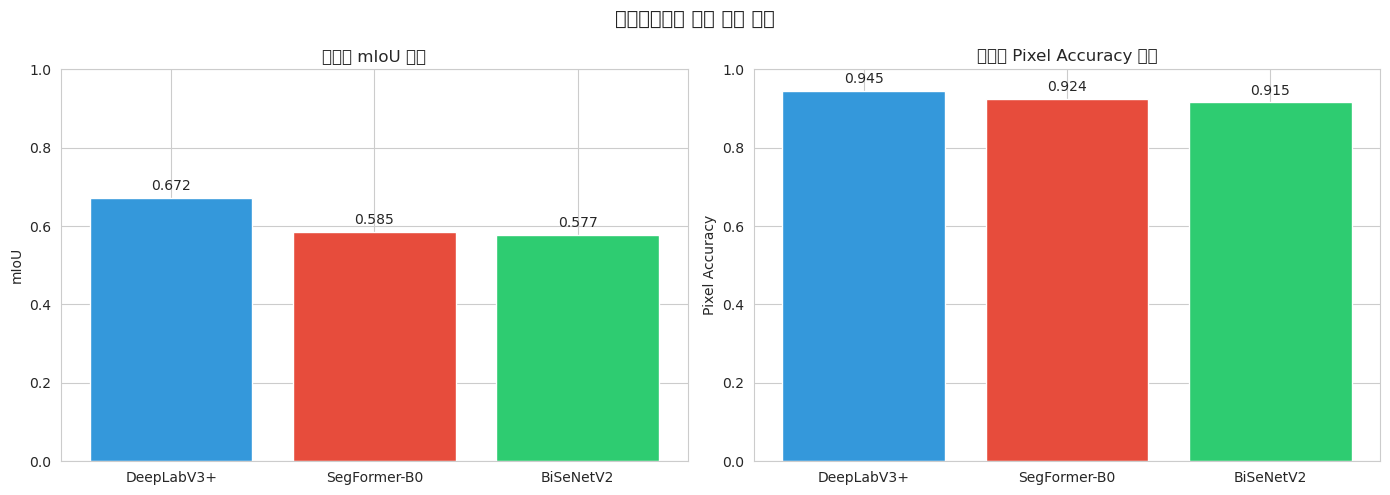

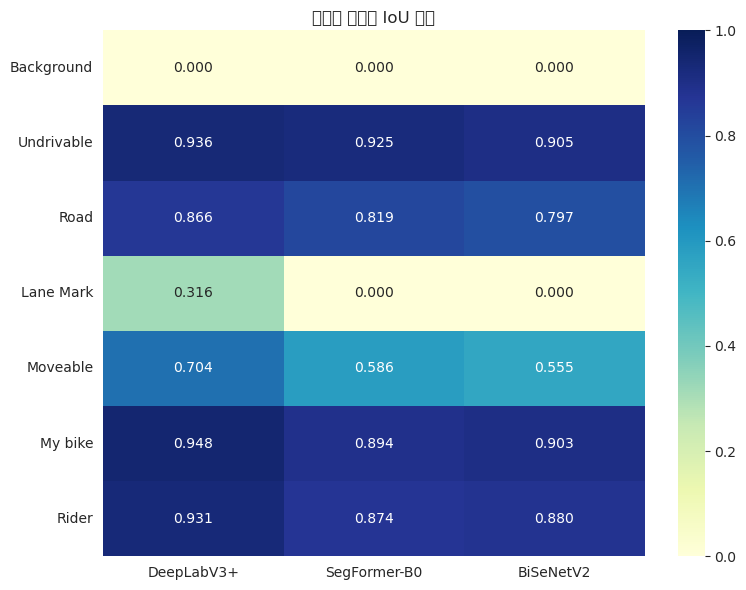


🏆 Best Model: DeepLabV3+ (mIoU=0.6716)


In [14]:
# ============================================================
# 3-5. 모델 비교 요약
# ============================================================
# 비교 테이블
comp_data = []
for name, res in all_results.items():
    comp_data.append({'Model': name, 'mIoU': res['miou'], 'Pixel Acc': res['pixel_acc']})
comp_df = pd.DataFrame(comp_data).sort_values('mIoU', ascending=False)
print('📊 모델 성능 비교:')
display(comp_df)

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = range(len(comp_df))
axes[0].bar(x, comp_df['mIoU'], color=['#3498db', '#e74c3c', '#2ecc71'][:len(comp_df)])
axes[0].set_xticks(x)
axes[0].set_xticklabels(comp_df['Model'])
axes[0].set_ylabel('mIoU')
axes[0].set_title('모델별 mIoU 비교')
axes[0].set_ylim(0, 1)
for i, v in enumerate(comp_df['mIoU']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

axes[1].bar(x, comp_df['Pixel Acc'], color=['#3498db', '#e74c3c', '#2ecc71'][:len(comp_df)])
axes[1].set_xticks(x)
axes[1].set_xticklabels(comp_df['Model'])
axes[1].set_ylabel('Pixel Accuracy')
axes[1].set_title('모델별 Pixel Accuracy 비교')
axes[1].set_ylim(0, 1)
for i, v in enumerate(comp_df['Pixel Acc']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.suptitle('세그멘테이션 모델 성능 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 클래스별 IoU 비교 히트맵
iou_df = pd.DataFrame({name: res['iou_per_class'] for name, res in all_results.items()}, index=class_names)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(iou_df, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax, vmin=0, vmax=1)
ax.set_title('모델별 클래스 IoU 비교')
plt.tight_layout()
plt.show()

# Best model 선택
best_name = comp_df.iloc[0]['Model']
best_model = all_results[best_name]['model']
best_type = all_results[best_name]['type']
print(f'\n🏆 Best Model: {best_name} (mIoU={all_results[best_name]["miou"]:.4f})')


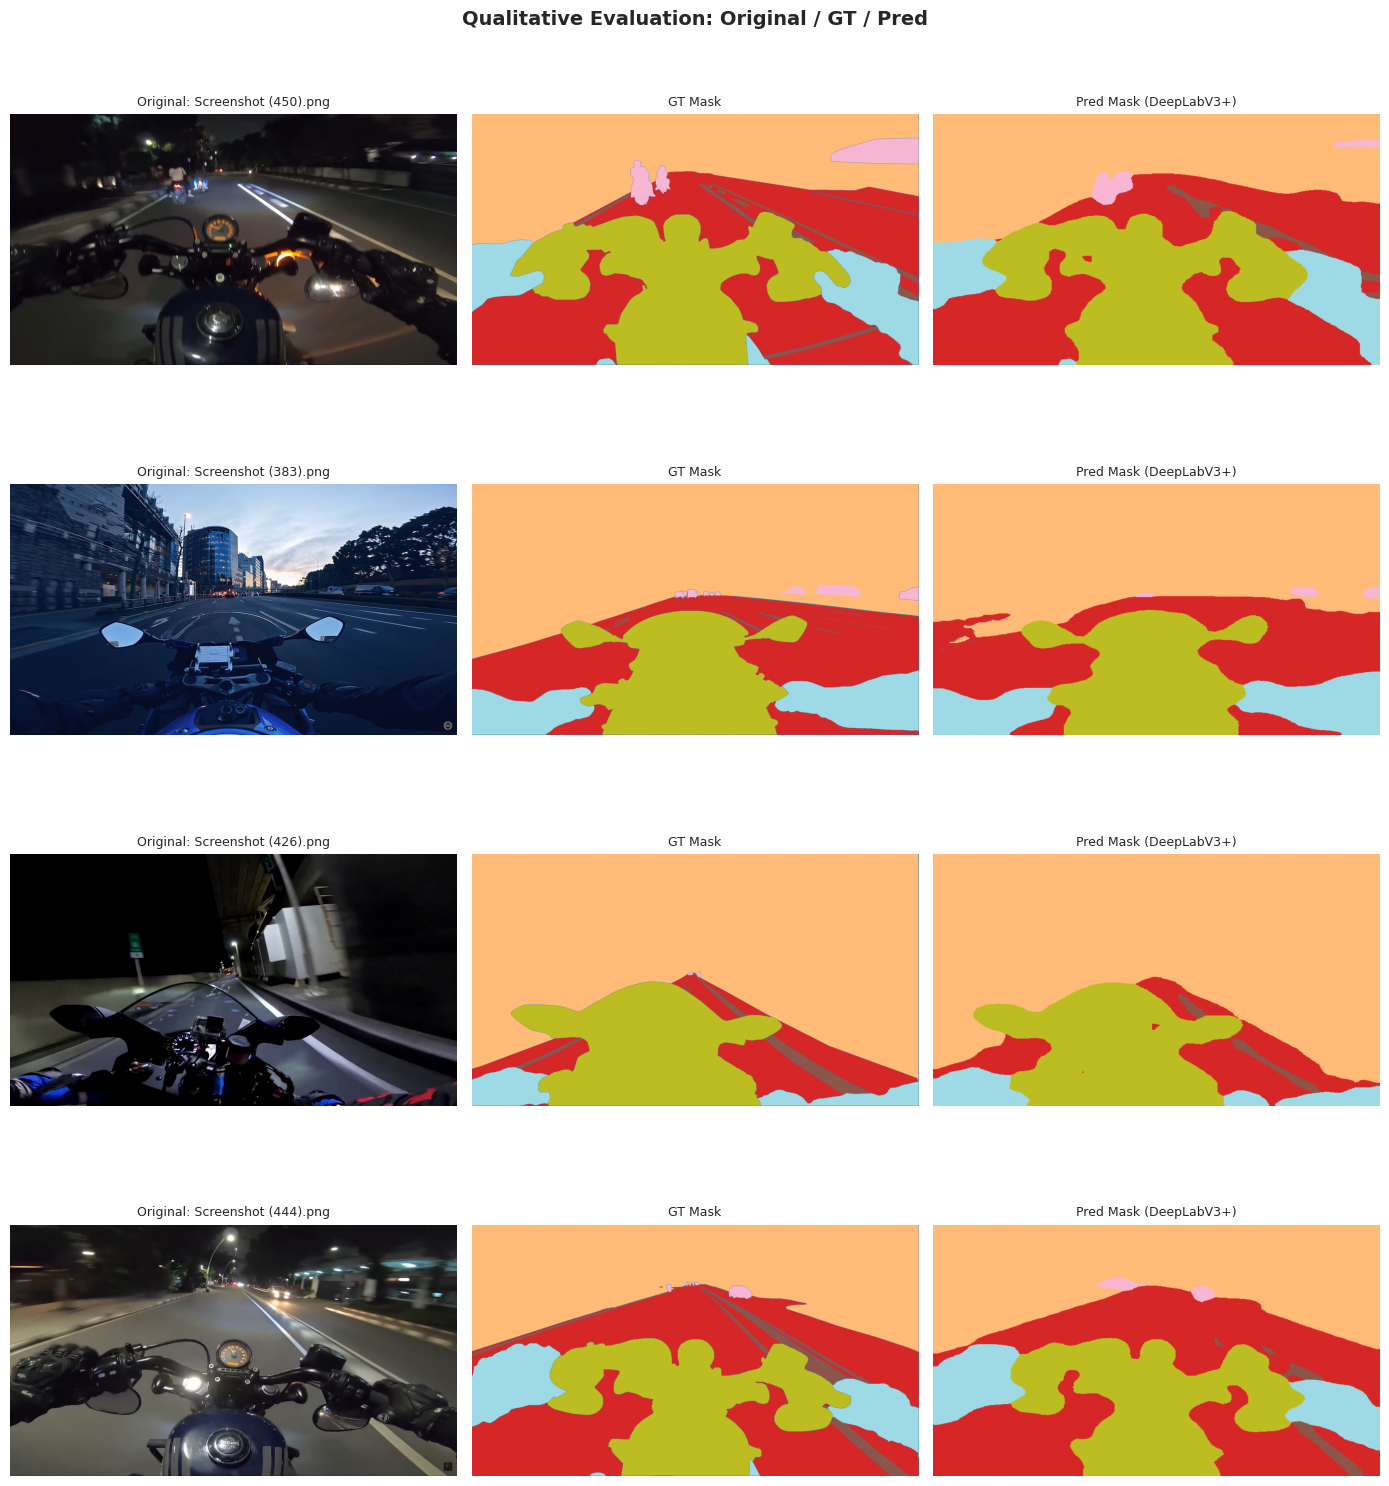

In [18]:
# ============================================================
# 3-6. 정성적 평가 (세그멘테이션 결과 출력)
# ============================================================
import numpy as np
import os
import torch
from PIL import Image
import matplotlib.pyplot as plt

def infer_pred_mask(model, img_tensor, device, model_type):
    """(C,H,W) tensor -> (H,W) pred mask (numpy)"""
    model.eval()
    x = img_tensor.unsqueeze(0).to(device)  # (1,C,H,W)
    with torch.no_grad():
        if model_type == "segformer":
            logits = model(x)                      # (1, num_classes, h, w)
        else:
            out = model(x)
            logits = out["out"] if isinstance(out, dict) and "out" in out else out
    return logits.argmax(1).squeeze(0).detach().cpu().numpy()

np.random.seed(42)
n_samples = 4

# pick valid samples from val_ids
picked = []
for _ in range(min(50, len(val_ids))):  # try up to 50 times
    img_id = int(np.random.choice(list(val_ids), 1)[0])
    info_list = coco.loadImgs([img_id])
    if not info_list:
        continue
    info = info_list[0]
    img_path = str(IMAGE_DIR) + "/" + info["file_name"]
    if not os.path.exists(img_path):
        continue
    picked.append(img_id)
    if len(picked) >= n_samples:
        break

if len(picked) == 0:
    raise RuntimeError("No valid samples found. Please check val_ids / IMAGE_DIR / coco.")

fig, axes = plt.subplots(len(picked), 3, figsize=(14, 4 * len(picked)))
if len(picked) == 1:
    axes = axes[np.newaxis, :]

for r, img_id in enumerate(picked):
    info = coco.loadImgs([img_id])[0]
    fname = info["file_name"]
    img_path = str(IMAGE_DIR) + "/" + fname

    img = np.array(Image.open(img_path).convert("RGB"))
    H, W = img.shape[:2]

    # GT mask (same size as original)
    gt_mask = create_class_mask(coco, img_id, cat_remap)

    # Pred mask (model output -> resize to original size)
    t = val_transform(image=img)
    img_tensor = t["image"].float()
    pred_mask_small = infer_pred_mask(best_model, img_tensor, device, best_type)

    # resize pred mask back to (H, W)
    pred_mask_img = Image.fromarray(pred_mask_small.astype(np.uint8))
    pred_mask_resized = np.array(
        pred_mask_img.resize((W, H), resample=Image.NEAREST)
    )

    # 1) Original
    axes[r, 0].imshow(img)
    axes[r, 0].set_title(f"Original: {fname}", fontsize=9)
    axes[r, 0].axis("off")

    # 2) Ground Truth (GT) mask
    axes[r, 1].imshow(gt_mask, cmap="tab20", vmin=0, vmax=num_classes - 1)
    axes[r, 1].set_title("GT Mask", fontsize=9)
    axes[r, 1].axis("off")

    # 3) Predicted mask (resized to original size)
    axes[r, 2].imshow(pred_mask_resized, cmap="tab20", vmin=0, vmax=num_classes - 1)
    axes[r, 2].set_title(f"Pred Mask ({best_name})", fontsize=9)
    axes[r, 2].axis("off")

plt.suptitle("Qualitative Evaluation: Original / GT / Pred", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

---
### 4. 다중 요인 기반 안전 점수 산출
---

단순 가중합 대신, **운전 안전의 4가지 독립 요인**을 분해하여 점수를 산출합니다.

### 설계 논리

**Factor 1: 도로 확보율 (40%)**
> 자기 차량을 제외한 시야에서 (Road + Lanemark) 비율. 50% 이상이면 만점.

**Factor 2: 장애물 위험도 (30%)**
> 이미지 **하단 50%** (= 카메라에 가까운 전방)에서 Movable 밀도. 공간적 위치를 반영.

**Factor 3: 차선 가시성 (15%)**
> Lanemark 비율이 기대치(2%) 이상이면 만점. 야간에 차선 미인식 = 이탈 위험.

**Factor 4: 시야 확보율 (15%)**
> Background(어둠) 외 식별 가능 영역 비율. 70% 이상 식별되면 만점.

$$\text{Safety} = 0.40 \times F_\text{road} + 0.30 \times F_\text{obstacle} + 0.15 \times F_\text{lane} + 0.15 \times F_\text{visibility}$$

⏳ DeepLabV3+으로 다중 요인 안전 점수 산출 중...
✅ 안전 점수 산출 완료 (40장)

📊 안전 점수 통계:
count    40.0
mean     74.2
std       7.7
min      54.8
25%      70.9
50%      75.2
75%      79.4
max      85.0
Name: safety_score, dtype: float64

📊 등급 분포:
grade
Safe       33
Caution     7
Name: count, dtype: int64


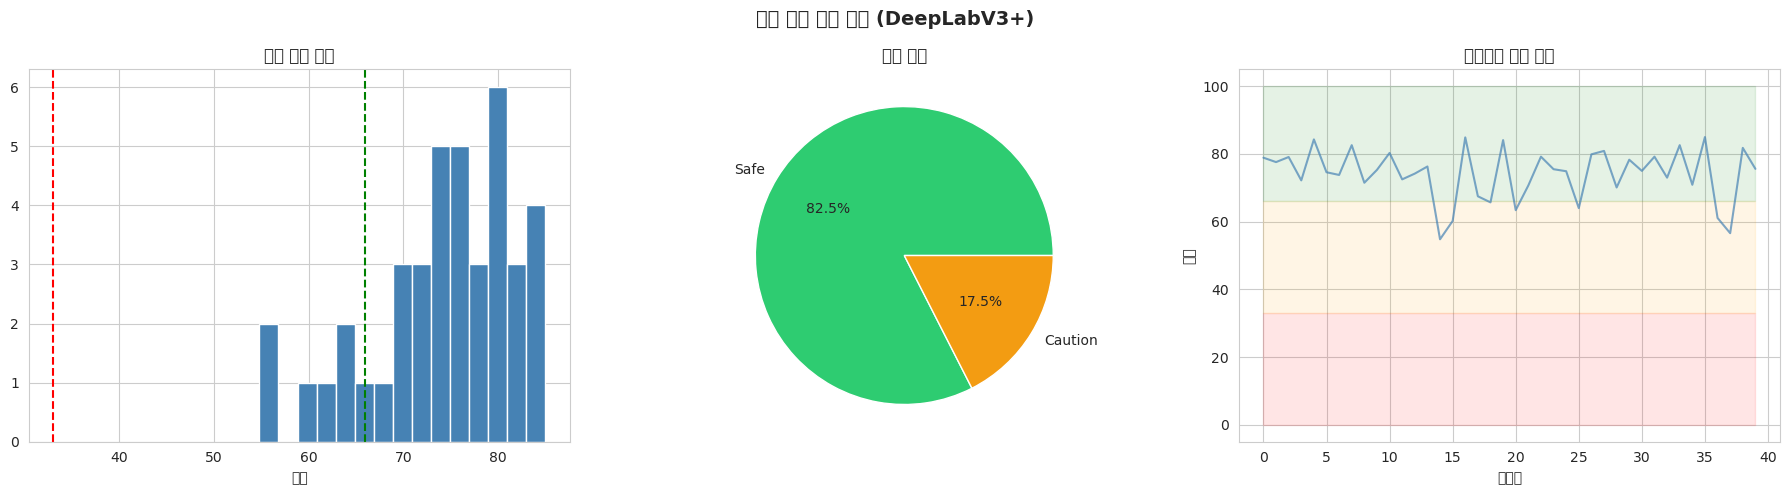

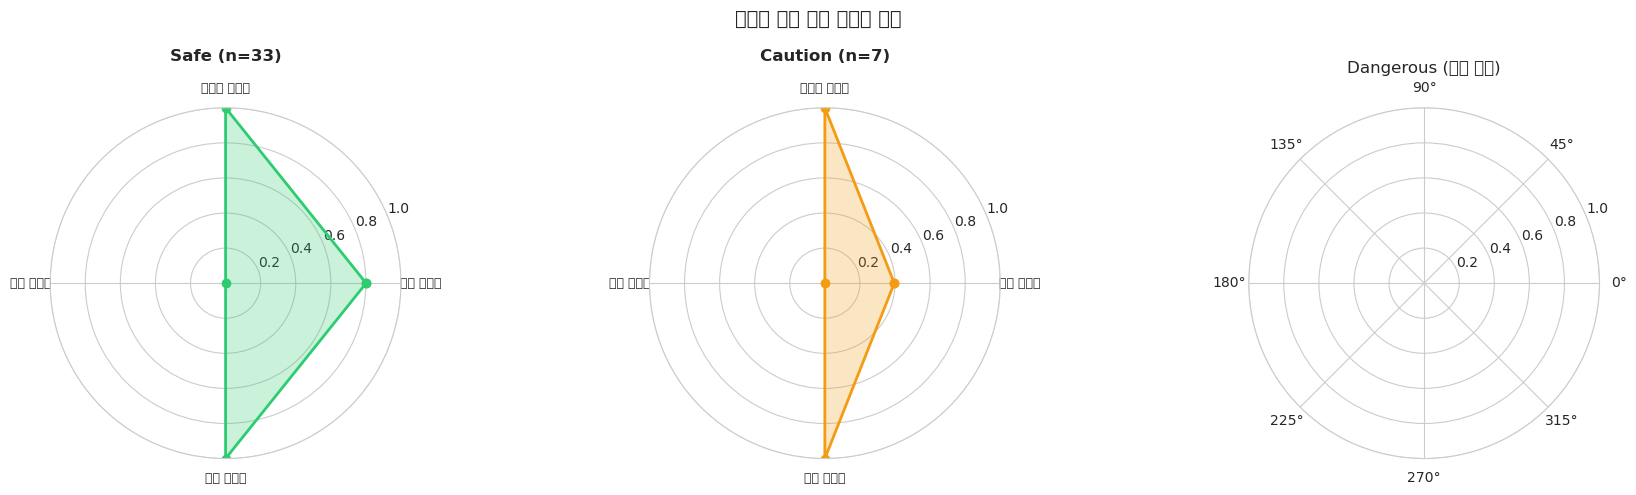

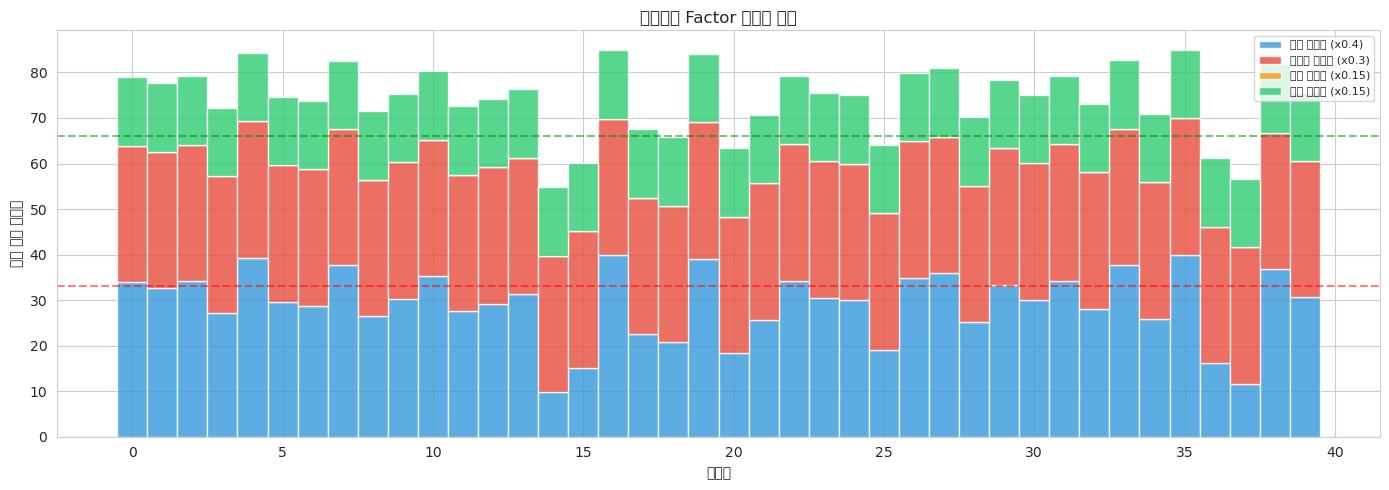


📊 Factor별 통계:


,도로 확보율,장애물 위험도,차선 가시성,시야 확보율
count,40.000,40.0,40.0,40.0
mean,0.730,1.0,0.0,1.0
std,0.193,0.0,0.0,0.0
min,0.244,1.0,0.0,1.0
25%,0.646,1.0,0.0,1.0
50%,0.754,1.0,0.0,1.0
75%,0.860,1.0,0.0,1.0
max,1.000,1.0,0.0,1.0



📌 Factor 해석:
        도로 확보율: 평균 0.730 🟢 양호
       장애물 위험도: 평균 1.000 🟢 양호
        차선 가시성: 평균 0.000 🔴 위험
        시야 확보율: 평균 1.000 🟢 양호


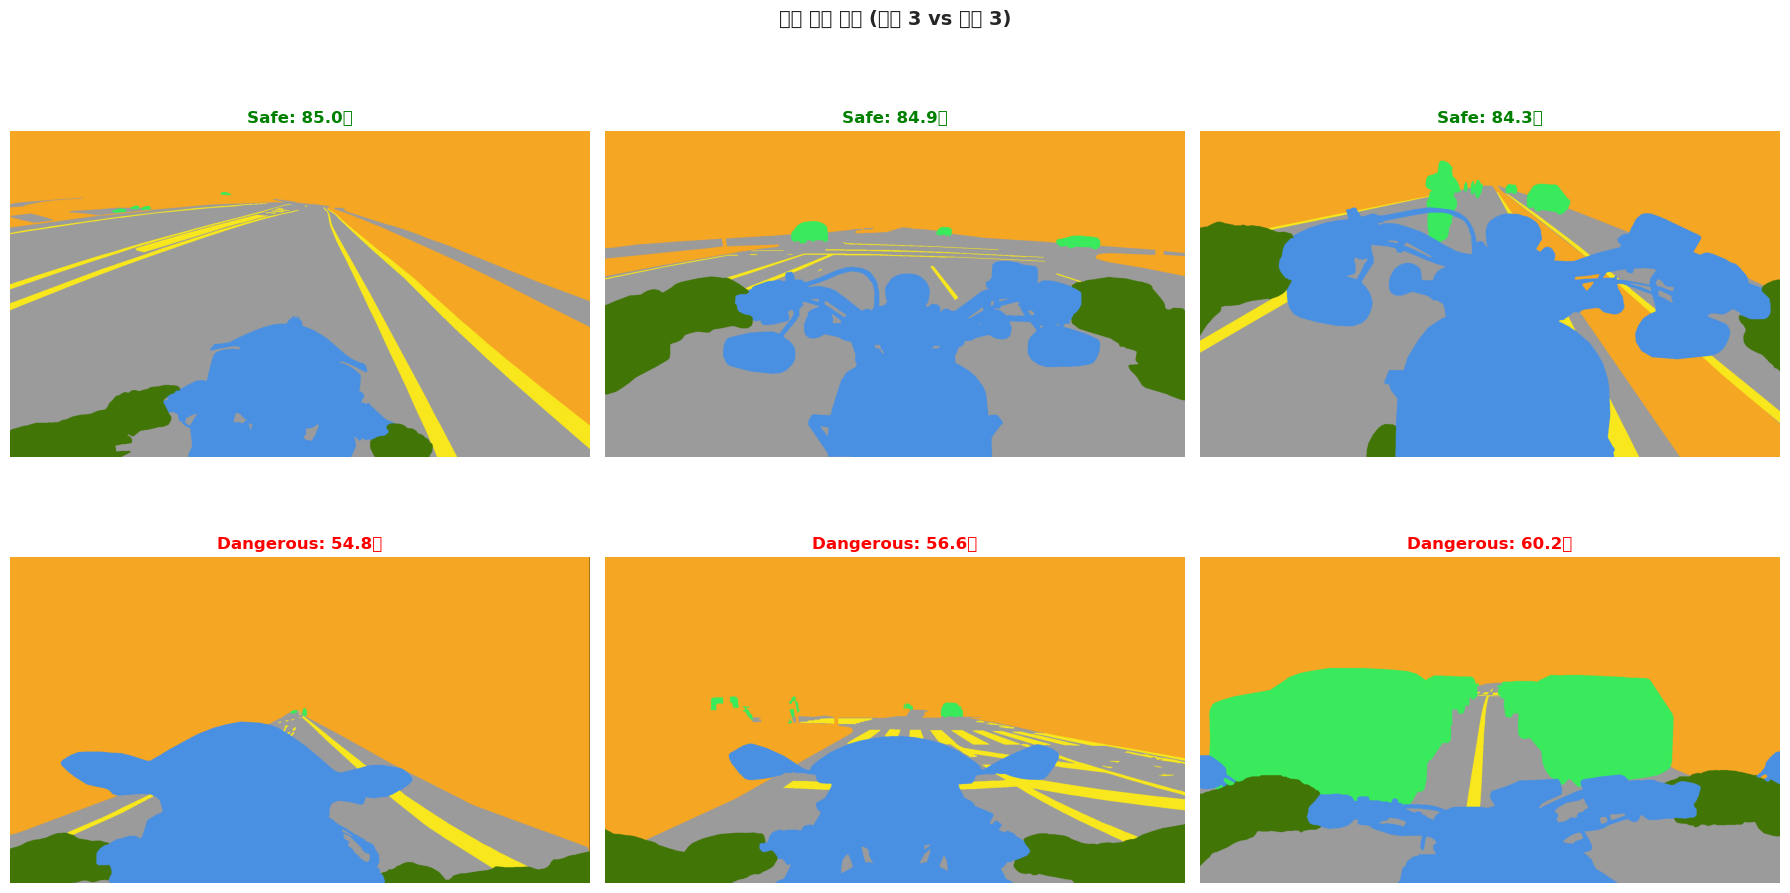

In [19]:
# ============================================================
# 4-1. 다중 요인 안전 점수 산출
# ============================================================
name_to_idx = {n: i for i, n in enumerate(class_names)}

def predict_mask(model, img_tensor, dev, model_type='standard'):
    model.eval()
    with torch.no_grad():
        x = img_tensor.unsqueeze(0).to(dev)
        if model_type == 'segformer':
            logits = model(pixel_values=x).logits
            logits = F.interpolate(logits, size=img_tensor.shape[-2:], mode='bilinear', align_corners=False)
        else:
            out = model(x)
            logits = out['out'] if isinstance(out, dict) else out
    return logits.argmax(1).squeeze(0).cpu().numpy()

def compute_multifactor_safety(pred_mask, name_to_idx):
    """
    다중 요인 안전 점수 산출
    Returns: (총점 0~1, Factor dict, 클래스별 비율 dict)
    """
    H, W = pred_mask.shape
    total = H * W

    # 클래스별 픽셀 수
    def px(name):
        idx = name_to_idx.get(name, -1)
        return int(np.sum(pred_mask == idx)) if idx >= 0 else 0

    road_px = px('Road')
    lane_px = px('Lane Mark')
    undrivable_px = px('Undrivable')
    movable_px = px('Movable')
    mybike_px = px('My bike')
    rider_px = px('Rider')
    bg_px = px('Background')

    # ---- Factor 1: 도로 확보율 (Road Availability) ----
    # 자기 차량 제외 영역 대비 주행 가능(Road+Lanemark) 비율
    non_self = total - mybike_px - rider_px
    drivable_ratio = (road_px + lane_px) / (non_self + 1e-10)
    f_road = min(drivable_ratio / 0.5, 1.0)  # 50% 이상이면 만점

    # ---- Factor 2: 장애물 위험도 (Obstacle Risk) ----
    # 이미지 하단 50% (전방 근거리)에서 Movable 밀도
    lower_half = pred_mask[H // 2:, :]
    movable_idx = name_to_idx.get('Movable', -1)
    movable_in_lower = int(np.sum(lower_half == movable_idx)) if movable_idx >= 0 else 0
    lower_total = lower_half.size
    obstacle_density = movable_in_lower / (lower_total + 1e-10)
    f_obstacle = max(1.0 - obstacle_density * 10, 0.0)  # 10% 이상이면 0점

    # ---- Factor 3: 차선 가시성 (Lane Visibility) ----
    lane_ratio = lane_px / (total + 1e-10)
    f_lane = min(lane_ratio / 0.02, 1.0)  # 2% 이상이면 만점

    # ---- Factor 4: 시야 확보율 (Visibility) ----
    identified_ratio = (total - bg_px) / (total + 1e-10)
    f_visibility = min(identified_ratio / 0.7, 1.0)  # 70% 이상 식별이면 만점

    # ---- 최종 점수 ----
    safety = 0.40 * f_road + 0.30 * f_obstacle + 0.15 * f_lane + 0.15 * f_visibility

    factors = {
        '도로 확보율': round(f_road, 4),
        '장애물 위험도': round(f_obstacle, 4),
        '차선 가시성': round(f_lane, 4),
        '시야 확보율': round(f_visibility, 4),
    }
    ratios = {
        'Road': road_px / total, 'Lanemark': lane_px / total,
        'Undrivable': undrivable_px / total, 'Movable': movable_px / total,
        'Background': bg_px / total,
    }
    return round(safety, 4), factors, ratios

# ---- 전체 Val 이미지에 대해 산출 ----
print(f'⏳ {best_name}으로 다중 요인 안전 점수 산출 중...')
safety_records = []

for img_id in val_ids:
    info = coco.loadImgs(img_id)[0]
    img = np.array(Image.open(IMAGE_DIR / info['file_name']).convert('RGB'))
    t = val_transform(image=img)
    img_tensor = t['image'].float()
    pred = predict_mask(best_model, img_tensor, device, best_type)
    score, factors, ratios = compute_multifactor_safety(pred, name_to_idx)
    safety_records.append({
        'image_id': img_id, 'file_name': info['file_name'],
        'safety_score': round(score * 100, 1), **factors, **ratios
    })

safety_df = pd.DataFrame(safety_records)
safety_df['grade'] = safety_df['safety_score'].apply(
    lambda s: 'Safe' if s >= 66 else ('Caution' if s >= 33 else 'Dangerous')
)

print(f'✅ 안전 점수 산출 완료 ({len(safety_df)}장)')
print(f'\n📊 안전 점수 통계:')
print(safety_df['safety_score'].describe().round(1))
print(f'\n📊 등급 분포:')
print(safety_df['grade'].value_counts())

# ---- 시각화 1: 점수 분포 + 등급 + 추이 ----
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(safety_df['safety_score'], bins=15, color='steelblue', edgecolor='white')
axes[0].axvline(33, color='red', linestyle='--')
axes[0].axvline(66, color='green', linestyle='--')
axes[0].set_title('안전 점수 분포')
axes[0].set_xlabel('점수')

grade_counts = safety_df['grade'].value_counts()
colors_pie = {'Safe': '#2ecc71', 'Caution': '#f39c12', 'Dangerous': '#e74c3c'}
axes[1].pie(grade_counts.values, labels=grade_counts.index,
            autopct='%1.1f%%', colors=[colors_pie.get(g, 'gray') for g in grade_counts.index])
axes[1].set_title('등급 분포')

axes[2].plot(range(len(safety_df)), safety_df['safety_score'].values, color='steelblue', alpha=0.7)
axes[2].fill_between(range(len(safety_df)), 0, 33, alpha=0.1, color='red')
axes[2].fill_between(range(len(safety_df)), 33, 66, alpha=0.1, color='orange')
axes[2].fill_between(range(len(safety_df)), 66, 100, alpha=0.1, color='green')
axes[2].set_title('프레임별 안전 점수')
axes[2].set_xlabel('프레임')
axes[2].set_ylabel('점수')

plt.suptitle(f'다중 요인 안전 점수 ({best_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ---- 시각화 2: Factor 분해 분석 (레이더 차트) ----
factor_cols = ['도로 확보율', '장애물 위험도', '차선 가시성', '시야 확보율']
factor_weights = [0.40, 0.30, 0.15, 0.15]

# 등급별 평균 Factor
fig, axes = plt.subplots(1, 3, figsize=(18, 5), subplot_kw=dict(polar=True))
angles = np.linspace(0, 2 * np.pi, len(factor_cols), endpoint=False).tolist()
angles += angles[:1]  # 닫기

for ax, grade in zip(axes, ['Safe', 'Caution', 'Dangerous']):
    subset = safety_df[safety_df['grade'] == grade]
    if len(subset) == 0:
        ax.set_title(f'{grade} (해당 없음)')
        continue
    means = [subset[c].mean() for c in factor_cols]
    means += means[:1]
    ax.fill(angles, means, alpha=0.25,
            color=colors_pie.get(grade, 'gray'))
    ax.plot(angles, means, 'o-', linewidth=2,
            color=colors_pie.get(grade, 'gray'))
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(factor_cols, fontsize=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'{grade} (n={len(subset)})', fontsize=12, fontweight='bold', pad=15)

plt.suptitle('등급별 안전 요인 레이더 차트', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ---- 시각화 3: Factor 기여도 Stacked Bar ----
fig, ax = plt.subplots(figsize=(14, 5))
bottom = np.zeros(len(safety_df))
colors_f = ['#3498db', '#e74c3c', '#f39c12', '#2ecc71']
for ci, col in enumerate(factor_cols):
    weighted = safety_df[col].values * factor_weights[ci] * 100
    ax.bar(range(len(safety_df)), weighted, bottom=bottom,
           label=f'{col} (x{factor_weights[ci]})', color=colors_f[ci], alpha=0.8, width=1.0)
    bottom += weighted
ax.axhline(33, color='red', linestyle='--', alpha=0.5)
ax.axhline(66, color='green', linestyle='--', alpha=0.5)
ax.set_xlabel('프레임')
ax.set_ylabel('안전 점수 기여도')
ax.set_title('프레임별 Factor 기여도 분해')
ax.legend(loc='upper right', fontsize=8)
plt.tight_layout()
plt.show()

# ---- Factor 통계 ----
print('\n📊 Factor별 통계:')
display(safety_df[factor_cols].describe().round(3))

print('\n📌 Factor 해석:')
for col in factor_cols:
    avg = safety_df[col].mean()
    status = '🟢 양호' if avg >= 0.7 else ('🟡 주의' if avg >= 0.4 else '🔴 위험')
    print(f'  {col:>12s}: 평균 {avg:.3f} {status}')

# ---- Safe / Dangerous 대표 프레임 ----
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, (_, row) in enumerate(safety_df.nlargest(3, 'safety_score').iterrows()):
    fuse_p = IMAGE_DIR / (row['file_name'] + '___fuse.png')
    orig_p = IMAGE_DIR / row['file_name']
    p = fuse_p if fuse_p.exists() else orig_p
    if p.exists():
        axes[0, i].imshow(Image.open(p))
    axes[0, i].set_title(f'Safe: {row["safety_score"]}점', color='green', fontweight='bold')
    axes[0, i].axis('off')

for i, (_, row) in enumerate(safety_df.nsmallest(3, 'safety_score').iterrows()):
    fuse_p = IMAGE_DIR / (row['file_name'] + '___fuse.png')
    orig_p = IMAGE_DIR / row['file_name']
    p = fuse_p if fuse_p.exists() else orig_p
    if p.exists():
        axes[1, i].imshow(Image.open(p))
    axes[1, i].set_title(f'Dangerous: {row["safety_score"]}점', color='red', fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('안전 등급 비교 (상위 3 vs 하위 3)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
### 6. 결론
---

### 6-1. 프로젝트 요약
- **데이터**: Motorcycle Night Ride 데이터셋 (~200장, 6클래스 세만틱 세그멘테이션)
- **모델**: DeepLabV3+, SegFormer-B0, BiSeNetV2 세 가지 세그멘테이션 모델을 fine-tuning
- **안전 점수**: 단순 가중합이 아닌 **4가지 독립 요인 기반 다중 안전 점수** 산출
- **XAI**: GradCAM으로 모델의 클래스별 주목 영역 시각화


### 6-2. 안전 점수 설계의 핵심 차별점
| 기존 방식 (단순 가중합) | 본 프로젝트 (다중 요인) |
|------------------------|----------------------|
| 전체 이미지 면적만 고려 | **공간적 위치** 반영 (하단 ROI = 전방) |
| 가중치에 도메인 근거 약함 | **운전 안전의 4가지 핵심 요인** 분해 |
| 결과 해석이 어려움 | **Factor별 기여도** 분해 가능 |
| My bike/Rider/Background 무시 | **자기 차량 제외, 시야 확보율** 반영 |



### 6-3. 주요 발견
1. **도로 확보율**이 안전 점수에 가장 큰 영향 (40%) — 전방 도로 넓이가 핵심
2. **장애물 위험도**는 전방(하단 ROI)에 Movable이 있을 때만 감점 — 공간 인식 반영
3. **야간 시야 확보율**이 의외로 변동이 큰 요인 — 조명/환경에 따라 크게 변화
4. 레이더 차트로 **등급별 약한 요인**을 직관적으로 파악 가능



### 6-4. Metric 근거
- **mIoU / Pixel Accuracy**: 세그멘테이션 모델 자체의 성능 평가
- **다중 요인 Safety Score**: 4개 요인 × 도메인 가중치 → 정량적 안전 평가
- **Factor 분해**: 어떤 요인 때문에 위험한지 **해석 가능한 점수** 제공



### 6-5. 한계 및 향후 과제
- **데이터 수 부족 (~200장)**: 더 큰 데이터셋과 결합 시 모델 성능 향상 기대
- **야간 전용**: 주간/악천후 일반화를 위해 다양한 환경 데이터 필요
- **단일 프레임 분석**: 영상 시계열 정보 활용 시 더 정교한 안전 평가 가능
- **Factor 가중치 최적화**: 실제 사고 데이터와 대조하여 가중치 자동 학습 가능
- **ROI 세분화**: 하단 50% 외에 좌/우/중앙 등 더 세밀한 공간 분할 가능
- 